# Treatment Heterogeneity and Conditional Effects

ECON526

Paul Schrimpf (University of British Columbia)

# Introduction

$$
\def\indep{\perp\!\!\!\perp}
\def\Er{\mathrm{E}}
\def\R{\mathbb{R}}
\def\En{{\mathbb{E}_n}}
\def\Pr{\mathrm{P}}
\newcommand{\norm}[1]{\left\Vert {#1} \right\Vert}
\newcommand{\abs}[1]{\left\vert {#1} \right\vert}
\def\inprob{{\,{\buildrel p \over \rightarrow}\,}}
\def\indist{\,{\buildrel d \over \rightarrow}\,}
\DeclareMathOperator*{\plim}{plim}
\DeclareMathOperator*{\argmax}{arg\,max}
\DeclareMathOperator*{\argmin}{arg\,min}
$$

## Conditional Average Effecst

-   Previously, mostly focused on average effects, e.g. $$
    ATE = \Er[Y_i(1) - Y_i(0)]
    $$
-   Also care about conditional average effects, e.g. $$
    CATE(x) = \Er[Y_i(1) - Y_i(0)|X_i = x]
    $$
    -   More detailed description
    -   Suggest mechanism for how treatment affects outcome
    -   Give treatment assignment rule, e.g. $$
        D_i = 1\{CATE(X_i) > 0 \}
        $$

## Conditional Average Effects: Challenges

$$
CATE(x) = \Er[Y_i(1) - Y_i(0)|X_i = x]
$$

-   Hard to communicate, espeically when $x$ high dimensional
-   Worse statistical properties, especially when $x$ high dimensional
    and/or continuous
-   More demanding of data
-   Focus on useful summaries of $CATE(x)$

# Example: Program Keluarga Harapan

## Program Keluarga Harapan

-   Alatas et al. (2011) , Triyana (2016)
-   Randomized experiment in Indonesia
-   Conditional cash transfer for pregnant women
    -   60-220USD (15-20% quarterly consumption)
    -   Conditions: 4 pre, 2 post natal medical visits, baby delivered
        by doctor or midwife
-   Randomly assigned at kecamatan (district) level

In [1]:
import pandas as pd
import numpy as np
import patsy
from sklearn import linear_model, ensemble, base, neural_network
import statsmodels.formula.api as smf
import statsmodels.api as sm
#from sklearn.utils._testing import ignore_warnings
#from sklearn.exceptions import ConvergenceWarning

import matplotlib.pyplot as plt
import seaborn as sns

## Data

In [2]:
url = "https://datascience.quantecon.org/assets/data/Triyana_2016_price_women_clean.csv"
df = pd.read_csv(url)
df.describe()

8 rows × 121 columns

## Average Treatment Effects

In [3]:
# some data prep for later
formula = """
bw ~ pkh_kec_ever +
  C(edu)*C(agecat) + log_xp_percap + hh_land + hh_home + C(dist) +
  hh_phone + hh_rf_tile + hh_rf_shingle + hh_rf_fiber +
  hh_wall_plaster + hh_wall_brick + hh_wall_wood + hh_wall_fiber +
  hh_fl_tile + hh_fl_plaster + hh_fl_wood + hh_fl_dirt +
  hh_water_pam + hh_water_mechwell + hh_water_well + hh_water_spring + hh_water_river +
  hh_waterhome +
  hh_toilet_own + hh_toilet_pub + hh_toilet_none +
  hh_waste_tank + hh_waste_hole + hh_waste_river + hh_waste_field +
  hh_kitchen +
  hh_cook_wood + hh_cook_kerosene + hh_cook_gas +
  tv + fridge + motorbike + car + goat + cow + horse
"""
bw, X = patsy.dmatrices(formula, df, return_type="dataframe")
# some categories are empty after dropping rows with Null, drop now
X = X.loc[:, X.sum() > 0]
bw = bw.iloc[:, 0]
treatment_variable = "pkh_kec_ever"
treatment = X["pkh_kec_ever"]
Xl = X.drop(["Intercept", "pkh_kec_ever", "C(dist)[T.313175]"], axis=1)
loc_id = df.loc[X.index, "Location_ID"].astype("category")

import re
# remove [ ] from names for compatibility with lightgbm
Xl = Xl.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [4]:
from statsmodels.iolib.summary2 import summary_col
tmp = pd.DataFrame(dict(birthweight=bw,treatment=treatment,assisted_delivery=df.loc[X.index, "good_assisted_delivery"]))
usage = smf.ols("assisted_delivery ~ treatment", data=tmp).fit(cov_type="cluster", cov_kwds={'groups':loc_id})
health= smf.ols("bw ~ treatment", data=tmp).fit(cov_type="cluster", cov_kwds={'groups':loc_id})
summary_col([usage, health])

Standard errors in parentheses.

## Conditional Average Treatment Effects

-   Can never recover individual treatment effect, $y_i(1)- y_i(0)$
-   Can estimate conditional averages: $$
    \begin{align*}
    E[y_i(1) - y_i(0) |X_i=x] = & E[y_i(1)|X_i = x] - E[y_i(0)|X_i=x] \\
    & \text{random assignment } \\
    = & E[y_i(1) | d_i = 1, X_i=x] - E[y_i(0) | d_i = 0, X_i=x] \\
    = & E[y_i | d_i = 1, X_i = x] - E[y_i | d_i = 0, X_i=x ]
    \end{align*}
    $$
-   But, inference and communication difficult

# Generic Machine Learning for Heterogeneous Effects

## Generic Machine Learning for Heterogeneous Effects in Randomized Experiments

-   Chernozhukov et al. (2023)
-   Designed based inference Imai and Li (2022)
-   Idea: use any machine learning estimator for
    $E[y_i | d_i = 0, X_i=x ]$
-   Report and do inference on lower dimensional summaries of
    $E[y_i(1) - y_i(0) |X_i=x]$

## Best Linear Projection of CATE

-   True $CATE(x)$, noisy proxy $\widehat{CATE}(x)$
-   Best linear projection: $$
    \beta_0, \beta_1 = \argmin_{b_0, b_1} \Er\left[\left(CATE(x) - b_0 - b_1(\widehat{CATE}(x) - E[\widehat{CATE}(x)])\right)^2 \right]
    $$
    -   $\beta_0 = \Er[y_i(1) - y_i(0)]$
    -   $\beta_1$ measures how well $\widehat{CATE}(x)$ proxies
        $CATE(x)$
-   Useful for comparing two proxies $\widehat{CATE}(x)$ and
    $\widetilde{CATE}(x)$

## Grouped Average Treatment Effects

-   Group observations by $\widehat{CATE}(x)$, reported averages
    conditional on group
-   Groups
    $G_{k}(x) = 1\{\ell_{k-1} \leq \widehat{CATE}(x) \leq \ell_k \}$
-   Grouped average treatment effects: $$
    \gamma_k = E[y(1) - y(0) | G_k(X)=1]
    $$

## Estimation

-   Regression with sample-splitting

-   BLP: $$
    y_i = \alpha_0 + \alpha_1 \widehat{B}(x_i) + \beta_0 (d_i-P(d=1)) + \beta_1
    (d_i-P(d=1))(\widehat{CATE}(x_i) - \overline{\widehat{CATE}(x_i)}) + \epsilon_i
    $$

    -   where $\widehat{B}(x_i)$ is an estimate of $\Er[y_i(0) | X_i=x]$

-   GATE: $$
    y_i = \alpha_0 + \alpha_1 \widehat{B}(x_i) + \sum_k \gamma_k (d_i-P(d=1)) 1(G_k(x_i)) +
    u_i
    $$

-   Estimates asymptotically normal with usual standard errors

## Code

In [5]:
# for clustering standard errors
def get_treatment_se(fit, cluster_id, rows=None):
    if cluster_id is not None:
        if rows is None:
            rows = [True] * len(cluster_id)
        vcov = sm.stats.sandwich_covariance.cov_cluster(fit, cluster_id.loc[rows])
        return np.sqrt(np.diag(vcov))

    return fit.HC0_se

## Code

In [6]:
def generic_ml_model(x, y, treatment, model, n_split=10, n_group=5, cluster_id=None):
    nobs = x.shape[0]

    blp = np.zeros((n_split, 2))
    blp_se = blp.copy()
    gate = np.zeros((n_split, n_group))
    gate_se = gate.copy()

    baseline = np.zeros((nobs, n_split))
    cate = baseline.copy()
    lamb = np.zeros((n_split, 2))

    for i in range(n_split):
        main = np.random.rand(nobs) > 0.5
        rows1 = ~main & (treatment == 1)
        rows0 = ~main & (treatment == 0)

        mod1 = base.clone(model).fit(x.loc[rows1, :], (y.loc[rows1]))
        mod0 = base.clone(model).fit(x.loc[rows0, :], (y.loc[rows0]))

        B = mod0.predict(x)
        S = mod1.predict(x) - B
        baseline[:, i] = B
        cate[:, i] = S
        ES = S.mean()

        ## BLP
        # assume P(treat|x) = P(treat) = mean(treat)
        p = treatment.mean()
        reg_df = pd.DataFrame(dict(
            y=y, B=B, treatment=treatment, S=S, main=main, excess_S=S-ES
        ))
        reg = smf.ols("y ~ B + I(treatment-p) + I((treatment-p)*(S-ES))", data=reg_df.loc[main, :])
        reg_fit = reg.fit()
        blp[i, :] = reg_fit.params.iloc[2:4]
        blp_se[i, :] = get_treatment_se(reg_fit, cluster_id, main)[2:]

        lamb[i, 0] = reg_fit.params.iloc[-1]**2 * S.var()

        ## GATEs
        cutoffs = np.quantile(S, np.linspace(0,1, n_group + 1))
        cutoffs[-1] += 1
        for k in range(n_group):
            reg_df[f"G{k}"] = (cutoffs[k] <= S) & (S < cutoffs[k+1])

        g_form = "y ~ B + " + " + ".join([f"I((treatment-p)*G{k})" for k in range(n_group)])
        g_reg = smf.ols(g_form, data=reg_df.loc[main, :])
        g_fit = g_reg.fit()
        gate[i, :] = g_fit.params.values[2:] #g_fit.params.filter(regex="G").values
        gate_se[i, :] = get_treatment_se(g_fit, cluster_id, main)[2:]

        lamb[i, 1] = (gate[i,:]**2).sum()/n_group

    out = dict(
        gate=gate, gate_se=gate_se,
        blp=blp, blp_se=blp_se,
        Lambda=lamb, baseline=baseline, cate=cate,
        name=type(model).__name__
    )
    return out


def generic_ml_summary(generic_ml_output):
    out = {
        x: np.nanmedian(generic_ml_output[x], axis=0)
        for x in ["blp", "blp_se", "gate", "gate_se", "Lambda"]
    }
    out["name"] = generic_ml_output["name"]
    return out

## Code

In [7]:
def generate_report(results):
    summaries = list(map(generic_ml_summary, results))
    df_plot = pd.DataFrame({
        mod["name"]: np.median(mod["cate"], axis=1)
        for mod in results
    })

    corrfig=sns.pairplot(df_plot, diag_kind="kde", kind="reg")

    df_cate = pd.concat({
        s["name"]: pd.DataFrame(dict(blp=s["blp"], se=s["blp_se"]))
        for s in summaries
    }).T.stack()

    df_groups = pd.concat({
        s["name"]: pd.DataFrame(dict(gate=s["gate"], se=s["gate_se"]))
        for s in summaries
    }).T.stack()
    return({"corr":df_plot.corr(), "pairplot":corrfig, "BLP":df_cate,"GATE":df_groups})

## Code

In [8]:
import lightgbm as lgb
import io
from contextlib import redirect_stdout, redirect_stderr
models = [
    linear_model.LassoCV(cv=10, n_alphas=25, max_iter=500, tol=1e-4, n_jobs=20),
    ensemble.RandomForestRegressor(n_estimators=200, min_samples_leaf=20, n_jobs=20),
    lgb.LGBMRegressor(n_estimators=200, max_depth=4, reg_lambda=1.0, reg_alpha=0.0, n_jobs=20),
    neural_network.MLPRegressor(hidden_layer_sizes=(20, 10), max_iter=500, activation="logistic",
                                solver="adam", tol=1e-3, early_stopping=True, alpha=0.0001)
]

kw = dict(x=Xl, treatment=treatment, n_split=11, n_group=5, cluster_id=loc_id)
def evaluate_models(models, y, **other_kw):
    all_kw = kw.copy()
    all_kw["y"] = y
    all_kw.update(other_kw)
    # hide many warnings while fitting
    with io.StringIO() as obuf, redirect_stdout(obuf):
        with io.StringIO() as ebuf, redirect_stderr(ebuf):
           results=list(map(lambda x: generic_ml_model(model=x, **all_kw), models))
           sout = obuf.getvalue()
           serr = ebuf.getvalue()
    return([results,sout,serr])

/home/paul/526/mine/site/env/lib/python3.12/site-packages/dask/dataframe/__init__.py:42: FutureWarning:


Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.



## Results: Birthweight

/tmp/ipykernel_682904/902487012.py:13: FutureWarning:

The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.

/tmp/ipykernel_682904/902487012.py:18: FutureWarning:

The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.

/tmp/ipykernel_682904/3631507206.py:3: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown


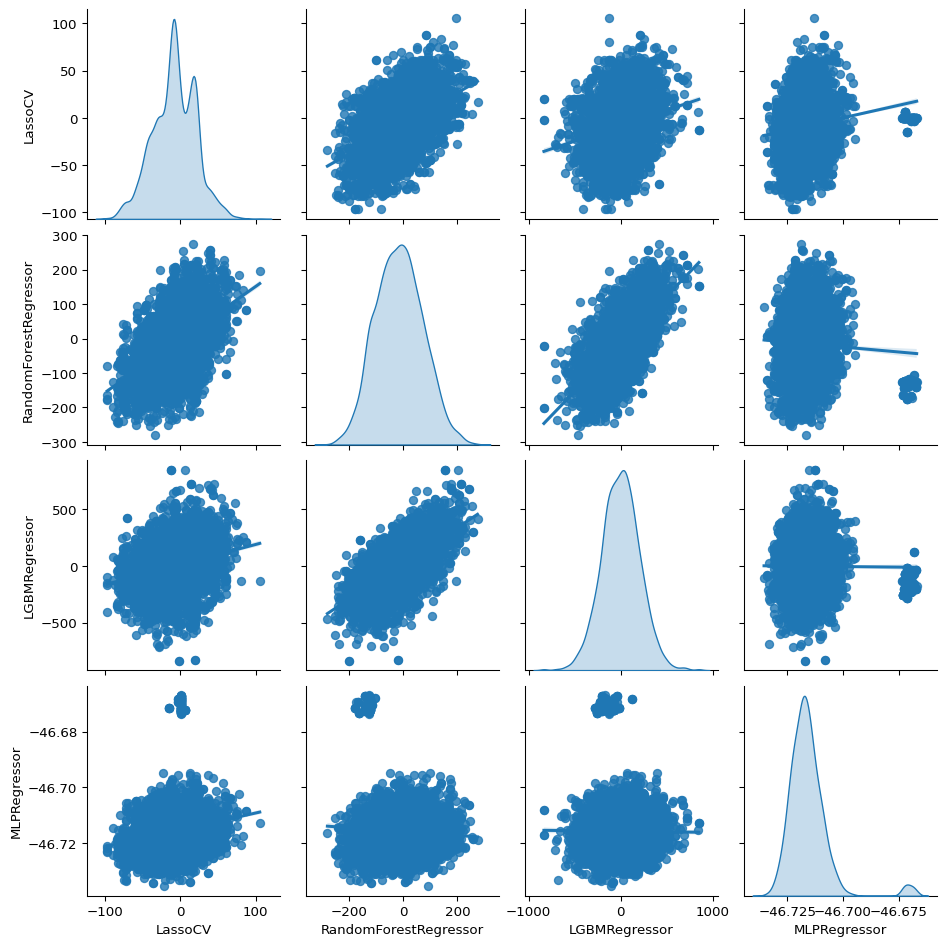

In [9]:
results = evaluate_models(models, y=bw);
report=generate_report(results[0])
report["pairplot"].fig.show()

## Results: Birthweight

In [10]:
report["corr"]

## Results: Birthweight

In [11]:
report["BLP"]

## Results: Birthweight

In [12]:
report["GATE"]

## Results: Assisted Delivery

/tmp/ipykernel_682904/902487012.py:13: FutureWarning:

The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.

/tmp/ipykernel_682904/902487012.py:18: FutureWarning:

The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.

/tmp/ipykernel_682904/2193773076.py:4: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown


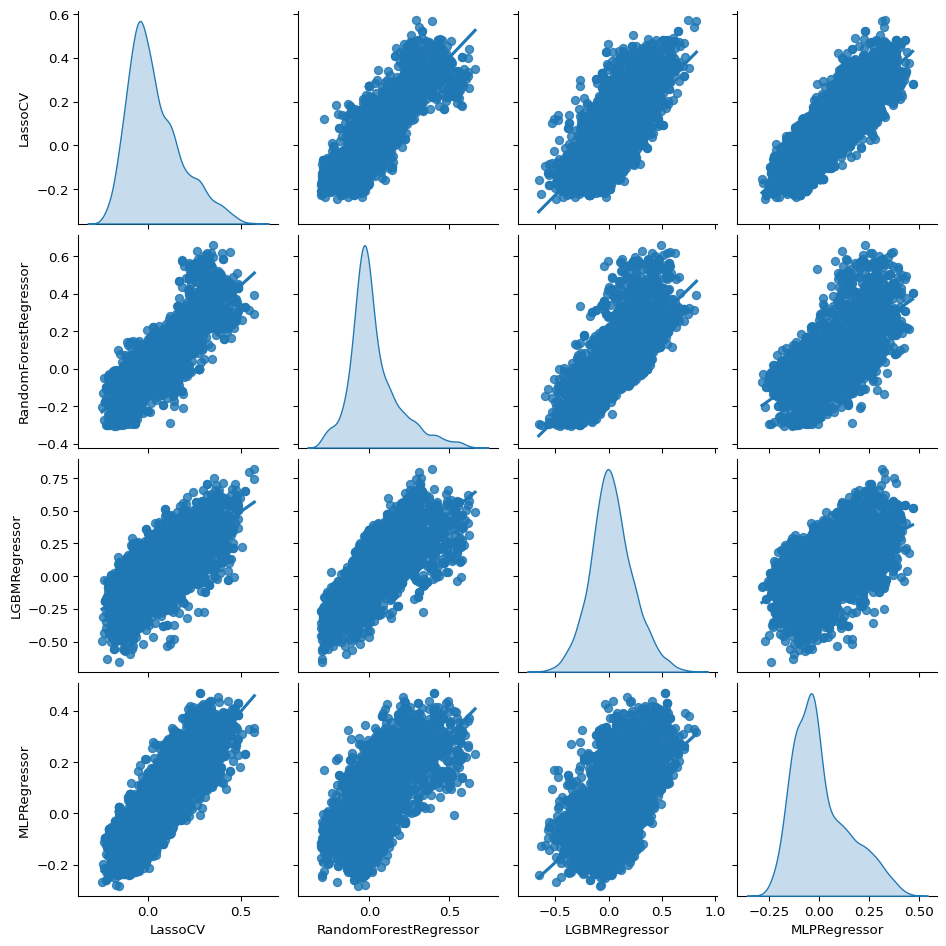

In [13]:
ad = df.loc[X.index, "good_assisted_delivery"]
results_ad = evaluate_models(models, y=ad)
report_ad=generate_report(results_ad[0])
report_ad["pairplot"].fig.show()

## Results: Assisted Delivery

In [14]:
report_ad["corr"]

## Results: Assisted Delivery

In [15]:
report_ad["BLP"]

## Results: Assisted Delivery

In [16]:
report_ad["GATE"]

## Covariate Means by Group

In [17]:
def cov_mean_by_group(y, res, cluster_id):
    n_group = res["gate"].shape[1]
    gate = res["gate"].copy()
    gate_se = gate.copy()
    dat = y.to_frame()

    for i in range(res["cate"].shape[1]):
        S = res["cate"][:, i]
        cutoffs = np.quantile(S, np.linspace(0, 1, n_group+1))
        cutoffs[-1] += 1
        for k in range(n_group):
            dat[f"G{k}"] = ((cutoffs[k] <= S) & (S < cutoffs[k+1])) * 1.0

        g_form = "y ~ -1 + " + " + ".join([f"G{k}" for k in range(n_group)])
        g_reg = smf.ols(g_form, data=dat.astype(float))
        g_fit = g_reg.fit()
        gate[i, :] = g_fit.params.filter(regex="G").values
        rows = ~y.isna()
        gate_se[i, :] = get_treatment_se(g_fit, cluster_id, rows)

    out = pd.DataFrame(dict(
        mean=np.nanmedian(gate, axis=0),
        se=np.nanmedian(gate_se, axis=0),
        group=list(range(n_group))
    ))

    return out

def compute_group_means_for_results(results, variables, df2):
    to_cat = []
    for res in results:
        for v in variables:
            to_cat.append(
                cov_mean_by_group(df2[v], res, loc_id)
                .assign(method=res["name"], variable=v)
            )

    group_means = pd.concat(to_cat, ignore_index=True)
    group_means["plus2sd"] = group_means.eval("mean + 1.96*se")
    group_means["minus2sd"] = group_means.eval("mean - 1.96*se")
    return group_means

def groupmeanfig(group_means):
    g = sns.FacetGrid(group_means, col="variable", col_wrap=min(3,group_means.variable.nunique()), hue="method", sharey=False)
    g.map(plt.plot, "group", "mean")
    g.map(plt.plot, "group", "plus2sd", ls="--")
    g.map(plt.plot, "group", "minus2sd", ls="--")
    g.add_legend();
    return(g)

## Covariate Means by Group

In [18]:
df2 = df.loc[X.index, :]
df2["edu99"] = df2.edu == 99
df2["educ"] = df2["edu"]
df2.loc[df2["edu99"], "educ"] = np.nan

variables1 = ["log_xp_percap","agecat","educ"]
variables2 =["tv","goat","cow",
             "motorbike", "hh_cook_wood","hh_toilet_own"]
group_means_ad = compute_group_means_for_results(results_ad[0], variables1, df2)

## Covariate Means by Group

/tmp/ipykernel_682904/131635368.py:2: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown


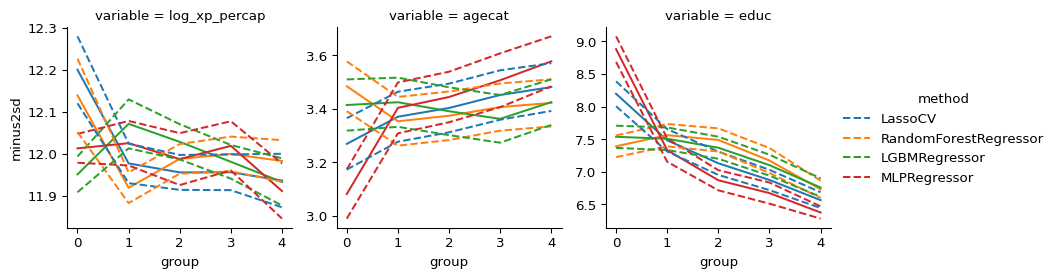

In [19]:
g = groupmeanfig(group_means_ad)
g.fig.show()

## Covariate Means by Group

/tmp/ipykernel_682904/1230240167.py:2: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown


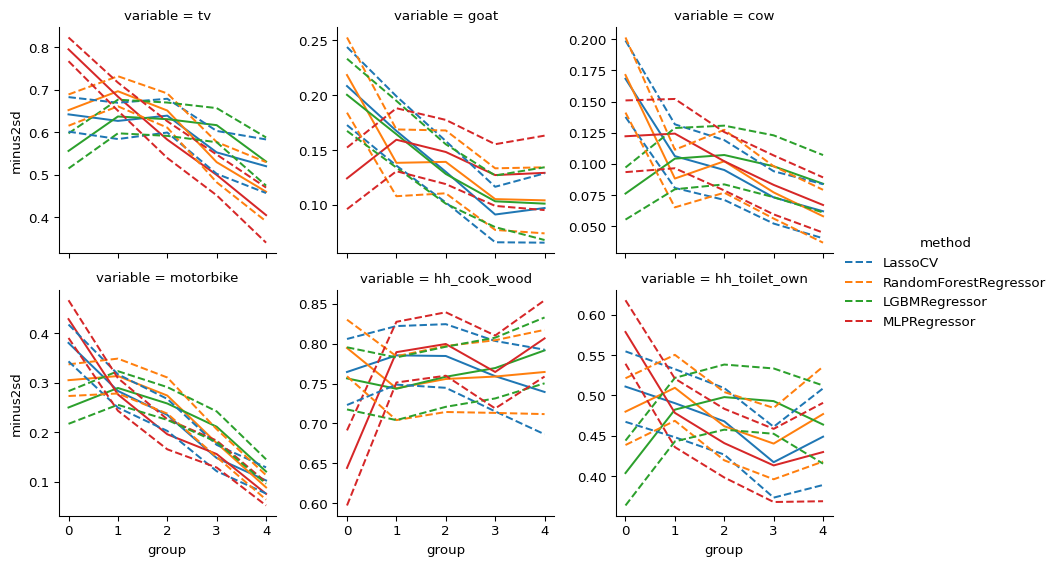

In [20]:
g = groupmeanfig(compute_group_means_for_results(results_ad[0], variables2, df2))
g.fig.show()

## Treatment Participation by Group

/tmp/ipykernel_682904/1755704608.py:2: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown


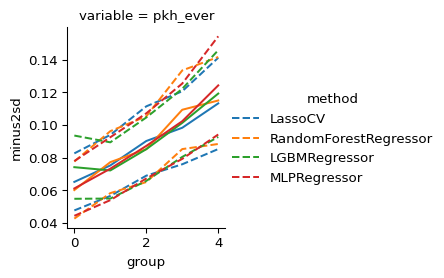

In [21]:
g = groupmeanfig(compute_group_means_for_results(results_ad[0], ["pkh_ever"], df2))
g.fig.show()

## Sources and Further Reading

-   Section on generic ML for heterogeneous effects is based on
    Chernozhukov et al. (2023) and my [earlier
    notes](https://datascience.quantecon.org/applications/heterogeneity.html)

## References

Alatas, Vivi, Nur Cahyadi, Elisabeth Ekasari, Sarah Harmoun, Budi
Hidayat, Edgar Janz, Jon Jellema, H Tuhiman, and M Wai-Poi. 2011.
“Program Keluarga Harapan : Impact Evaluation of Indonesia’s Pilot
Household Conditional Cash Transfer Program.” World Bank.
<http://documents.worldbank.org/curated/en/589171468266179965/Program-Keluarga-Harapan-impact-evaluation-of-Indonesias-Pilot-Household-Conditional-Cash-Transfer-Program>.

Chernozhukov, Victor, Mert Demirer, Esther Duflo, and Iván
Fernández-Val. 2023. “Generic Machine Learning Inference on Heterogenous
Treatment Effects in Randomized Experiments, with an Application to
Immunization in India.”

Imai, Kosuke, and Michael Lingzhi Li. 2022. “Statistical Inference for
Heterogeneous Treatment Effects Discovered by Generic Machine Learning
in Randomized Experiments.” In.
<https://api.semanticscholar.org/CorpusID:247762848>.

Triyana, Margaret. 2016. “Do Health Care Providers Respond to
Demand-Side Incentives? Evidence from Indonesia.” *American Economic
Journal: Economic Policy* 8 (4): 255–88.
<https://doi.org/10.1257/pol.20140048>.